In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec
import matplotlib as mpl

landmask = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/landmask.nc")['mask']

cmap_continuous = mpl.colors.ListedColormap(['#FFF9C4', '#FFD54F', '#FF8A65', '#D84315', '#4E342E'])
cmap_continuous.set_under('white')
levels_continuous = [1, 2, 3, 4, 5]
cmap_change = mpl.colors.ListedColormap(['#1E5A96', '#508CC8', '#96BEE6', '#D2E6FA', '#FFFFFF', '#FFE6C8', '#FFBE82', '#FF9646', '#E6641E'])
cmap_change.set_over('#B43C00')
cmap_change.set_under('#003264')
levels_change = [-16, -12, -8, -4, -1, 1, 4, 8, 12, 16]
def add_unified_colorbar(fig, ax, mesh, label, extend='both', show_texts=True):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - 0.035  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend=extend)
    if show_texts:
        # 在 colorbar 上方左侧添加文字
        cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=16, transform=cbar.ax.transAxes)

        # 在 colorbar 上方右侧添加文字
        cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=16, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label, fontsize=18)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if not fig:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def draw_hotpoint_labels(hotpoint_label, fig=None, ax=None, fontsize=16, fontweight='bold', color='black'):
    """
    在指定坐标位置标注区域名称

    参数:
    hotpoint_label: 包含区域名称和标注坐标的字典
    fig: 图形对象
    ax: 坐标轴对象
    fontsize: 字体大小
    fontweight: 字体粗细
    color: 文字颜色
    """
    for region_name, coords in hotpoint_label.items():
        lat, lon = coords
        ax.text(lon, lat, region_name,
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',      # 水平对齐方式
                va='center',      # 垂直对齐方式
                transform=ccrs.PlateCarree(),)

In [2]:
def plot_extendedfig3a(fig, ax):
    SPEI_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_historical.nc")['historical_SPEI12']
    SPEI_HISTORICAL = SPEI_HISTORICAL.where(landmask == 1)
    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SPEI_HISTORICAL.lon.values
    lats = SPEI_HISTORICAL.lat.values

    lon_min, lon_max = SPEI_HISTORICAL.lon.min().values, SPEI_HISTORICAL.lon.max().values
    lat_min, lat_max = SPEI_HISTORICAL.lat.min().values, SPEI_HISTORICAL.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SPEI_HISTORICAL.lon)
    d_lat = (lat_max - lat_min) / len(SPEI_HISTORICAL.lat)

    # 设置colormap和norm
    cmap = plt.get_cmap("GnBu")
    vmin = SPEI_HISTORICAL.min().item()
    vmax = SPEI_HISTORICAL.max().item()
    norm = plt.Normalize(vmin, vmax)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SPEI_HISTORICAL[i, j].item()):
                continue

            value = SPEI_HISTORICAL[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("The maximum Duration of SPEI", fontsize=16, pad=15)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(0, 91, 10))
    cbar = add_unified_colorbar(fig, ax, sm, "Historical Maximum Duration of SPEI (months)", extend='neither', show_texts=False)
    cbar.set_ticks(np.arange(0, 25, 4))

    # 添加图例标识
    ax.text(-0.1, 1.1, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [3]:
def plot_extendedfig3b(fig, ax):
    CONTINUOUS_DRYING_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/ContinuouslyDrying_historical.nc")['drying_trend']
    CONTINUOUS_DRYING_SSP126 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/ContinuouslyDrying_ssp126.nc")['drying_trend']
    CONTINUOUS_DRYING_SSP245 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/ContinuouslyDrying_ssp245.nc")['drying_trend']
    CONTINUOUS_DRYING_SSP370 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/ContinuouslyDrying_ssp370.nc")['drying_trend']
    CONTINUOUS_DRYING_SSP585 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/ContinuouslyDrying_ssp585.nc")['drying_trend']

    CONTINUOUS_DRYING_TOTAL = CONTINUOUS_DRYING_HISTORICAL + CONTINUOUS_DRYING_SSP126 + CONTINUOUS_DRYING_SSP245 + CONTINUOUS_DRYING_SSP370 + CONTINUOUS_DRYING_SSP585

    # 把CONTINUOUS_DRYING_TOTAL中landmask为0的地方设为nan
    CONTINUOUS_DRYING_TOTAL = CONTINUOUS_DRYING_TOTAL.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = CONTINUOUS_DRYING_TOTAL.lon.values
    lats = CONTINUOUS_DRYING_TOTAL.lat.values

    lon_min, lon_max = CONTINUOUS_DRYING_TOTAL.lon.min().values, CONTINUOUS_DRYING_TOTAL.lon.max().values
    lat_min, lat_max = CONTINUOUS_DRYING_TOTAL.lat.min().values, CONTINUOUS_DRYING_TOTAL.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(CONTINUOUS_DRYING_TOTAL.lon)
    d_lat = (lat_max - lat_min) / len(CONTINUOUS_DRYING_TOTAL.lat)

    # 设置colormap和norm
    # cmap = plt.get_cmap("PiYG")
    vmin = CONTINUOUS_DRYING_TOTAL.min().item()
    vmax = CONTINUOUS_DRYING_TOTAL.max().item()
    # norm = plt.Normalize(vmin, vmax)
    cmap = cmap_continuous
    norm = mpl.colors.BoundaryNorm(levels_continuous, cmap.N)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(CONTINUOUS_DRYING_TOTAL[i, j].item()):
                continue

            value = CONTINUOUS_DRYING_TOTAL[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(0, 91, 10))
    cbar = add_unified_colorbar(fig, ax, sm, "", extend='neither', show_texts=False)

    # 添加图例标识
    ax.text(-0.1, 1.1, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [4]:
def plot_extendedfig3c(fig, ax):
    SPEI_SSP585 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_ssp585.nc")['ssp585_SPEI12']
    SPEI_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_historical.nc")['historical_SPEI12']

    SPEI_MAX_DUR_CHANGE = SPEI_SSP585 - SPEI_HISTORICAL
    # 把SPEI_MAX_DUR_CHANGE中landmask为0的地方设为nan
    SPEI_MAX_DUR_CHANGE = SPEI_MAX_DUR_CHANGE.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SPEI_MAX_DUR_CHANGE.lon.values
    lats = SPEI_MAX_DUR_CHANGE.lat.values

    lon_min, lon_max = SPEI_MAX_DUR_CHANGE.lon.min().values, SPEI_MAX_DUR_CHANGE.lon.max().values
    lat_min, lat_max = SPEI_MAX_DUR_CHANGE.lat.min().values, SPEI_MAX_DUR_CHANGE.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SPEI_MAX_DUR_CHANGE.lon)
    d_lat = (lat_max - lat_min) / len(SPEI_MAX_DUR_CHANGE.lat)

    # 设置colormap和norm
    # cmap = plt.get_cmap("PiYG")
    vmin = SPEI_MAX_DUR_CHANGE.min().item()
    vmax = SPEI_MAX_DUR_CHANGE.max().item()
    # norm = plt.Normalize(vmin, vmax)
    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SPEI_MAX_DUR_CHANGE[i, j].item()):
                continue

            value = SPEI_MAX_DUR_CHANGE[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SPEI_MAX_DUR_CHANGE.values > 0)
    negative_count = np.sum(SPEI_MAX_DUR_CHANGE.values < 0)
    total_count = positive_count + negative_count

    # 创建左下角的饼图坐标轴 (使用相对坐标定位)
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])  # [x, y, width, height]

    # 绘制饼图
    colors = ['#ff7f0e', '#1f77b4']  # 橙色表示增加，蓝色表示减少
    pie_ax.pie(
        [positive_count, negative_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width': 0.65},
        textprops={'fontsize': 14}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the maximum Duration of SPEI", fontsize=16, pad=15)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(0, 91, 10))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [5]:
def plot_extendedfig3d(fig, ax):
    SSMI_SSP585 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SSMI_ssp585.nc")['ssp585_SSMI12']
    SSMI_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SSMI_historical.nc")['historical_SSMI12']

    SSMI_MAX_DUR_CHANGE = SSMI_SSP585 - SSMI_HISTORICAL
    # 把SPEI_MAX_DUR_CHANGE中landmask为0的地方设为nan
    SSMI_MAX_DUR_CHANGE = SSMI_MAX_DUR_CHANGE.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_MAX_DUR_CHANGE.lon.values
    lats = SSMI_MAX_DUR_CHANGE.lat.values

    lon_min, lon_max = SSMI_MAX_DUR_CHANGE.lon.min().values, SSMI_MAX_DUR_CHANGE.lon.max().values
    lat_min, lat_max = SSMI_MAX_DUR_CHANGE.lat.min().values, SSMI_MAX_DUR_CHANGE.lat.max().values

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_MAX_DUR_CHANGE.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_MAX_DUR_CHANGE.lat)

    # 设置colormap和norm
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_MAX_DUR_CHANGE.min().item()
    vmax = SSMI_MAX_DUR_CHANGE.max().item()
    # norm = plt.Normalize(vmin, vmax)
    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            # 跳过海洋/无效值
            if np.isnan(SSMI_MAX_DUR_CHANGE[i, j].item()):
                continue

            value = SSMI_MAX_DUR_CHANGE[i, j].item()

            # 创建圆角矩形路径
            patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor=cmap(norm(value)),
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder = 1
                )
            ax.add_patch(patch)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_MAX_DUR_CHANGE.values > 0)
    negative_count = np.sum(SSMI_MAX_DUR_CHANGE.values < 0)
    total_count = positive_count + negative_count

    # 创建左下角的饼图坐标轴 (使用相对坐标定位)
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])  # [x, y, width, height]

    # 绘制饼图
    colors = ['#ff7f0e', '#1f77b4']  # 橙色表示增加，蓝色表示减少
    pie_ax.pie(
        [positive_count, negative_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width': 0.65},
        textprops={'fontsize': 14}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the maximum Duration of SSMI", fontsize=16, pad=15)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(0, 91, 10))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'd',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [6]:
def plot_extendedfig3e(fig, ax):
    # 绘制小提琴图
    SPEI_SSP585 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_ssp585.nc")['ssp585_SPEI12']
    SPEI_SSP126 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_ssp126.nc")['ssp126_SPEI12']
    SPEI_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SPEI_historical.nc")['historical_SPEI12']
    
    # 应用陆地掩膜
    SPEI_SSP585 = SPEI_SSP585.where(landmask == 1)
    SPEI_SSP126 = SPEI_SSP126.where(landmask == 1)
    SPEI_HISTORICAL = SPEI_HISTORICAL.where(landmask == 1)
    
    # 提取有效值（排除NaN）
    data_hist = SPEI_HISTORICAL.values.flatten()
    data_hist = data_hist[~np.isnan(data_hist)]
    
    data_ssp126 = SPEI_SSP126.values.flatten()
    data_ssp126 = data_ssp126[~np.isnan(data_ssp126)]
    
    data_ssp585 = SPEI_SSP585.values.flatten()
    data_ssp585 = data_ssp585[~np.isnan(data_ssp585)]
    
    # 准备小提琴图数据
    data = [data_hist, data_ssp126, data_ssp585]
    labels = ['Historical', 'SSP1-2.6', 'SSP5-8.5']
    colors = ['#808080', '#1f77b4', '#d62728']  # 灰色、蓝色、红色
    
    # 绘制小提琴图
    parts = ax.violinplot(
        data, 
        showmeans=True,
        showmedians=True,
        showextrema=False
    )
    
    # 设置颜色
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.8)

    # 设置平均值线属性
    parts['cmeans'].set_edgecolor('green')
    parts['cmeans'].set_linewidth(2)
    
    # 设置中位数线属性
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(1.5)
    
    # 添加箱线图元素（显示四分位数）
    quartiles = [np.percentile(d, [25, 50, 75]) for d in data]
    whiskers = [np.array([
        np.percentile(d, 0), 
        np.percentile(d, 100)
    ]) for d in data]
    
    for i, q in enumerate(quartiles):
        # 绘制箱体
        ax.vlines(i+1, q[0], q[2], color='k', linestyle='-', lw=5)
        # 绘制中位数
        ax.vlines(i+1, q[1], q[1], color='k', linestyle='-', lw=3)
        # 绘制须线
        ax.hlines(q[0], i+0.9, i+1.1, color='k', linestyle='-', lw=1)
        ax.hlines(q[2], i+0.9, i+1.1, color='k', linestyle='-', lw=1)

    
    # 设置坐标轴标签
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel('Maximum Drying Duration (months)', fontsize=14)
    
    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # 添加图例标识
    ax.text(0, 1, 'e',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',)
    
    # 添加标题
    ax.set_title('Distribution of Maximum \nDrying Duration of SPEI', fontsize=16, pad=15)

In [7]:
def plot_extendedfig3f(fig, ax):
    # 绘制小提琴图
    SSMI_SSP585 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SSMI_ssp585.nc")['ssp585_SSMI12']
    SSMI_SSP126 = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SSMI_ssp126.nc")['ssp126_SSMI12']
    SSMI_HISTORICAL = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/MaxDryingDuration_SSMI_historical.nc")['historical_SSMI12']
    
    # 应用陆地掩膜
    SSMI_SSP585 = SSMI_SSP585.where(landmask == 1)
    SSMI_SSP126 = SSMI_SSP126.where(landmask == 1)
    SSMI_HISTORICAL = SSMI_HISTORICAL.where(landmask == 1)
    
    # 提取有效值（排除NaN）
    data_hist = SSMI_HISTORICAL.values.flatten()
    data_hist = data_hist[~np.isnan(data_hist)]
    
    data_ssp126 = SSMI_SSP126.values.flatten()
    data_ssp126 = data_ssp126[~np.isnan(data_ssp126)]
    
    data_ssp585 = SSMI_SSP585.values.flatten()
    data_ssp585 = data_ssp585[~np.isnan(data_ssp585)]
    
    # 准备小提琴图数据
    data = [data_hist, data_ssp126, data_ssp585]
    labels = ['Historical', 'SSP1-2.6', 'SSP5-8.5']
    colors = ['#808080', '#1f77b4', '#d62728']  # 灰色、蓝色、红色
    
    # 绘制小提琴图
    parts = ax.violinplot(
        data, 
        showmeans=True,
        showmedians=True,
        showextrema=False
    )
    
    # 设置颜色
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.8)

    # 设置平均值线属性
    parts['cmeans'].set_edgecolor('green')
    parts['cmeans'].set_linewidth(2)
    
    # 设置中位数线属性
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(1.5)
    
    # 添加箱线图元素（显示四分位数）
    quartiles = [np.percentile(d, [25, 50, 75]) for d in data]
    whiskers = [np.array([
        np.percentile(d, 0), 
        np.percentile(d, 100)
    ]) for d in data]
    
    for i, q in enumerate(quartiles):
        # 绘制箱体
        ax.vlines(i+1, q[0], q[2], color='k', linestyle='-', lw=5)
        # 绘制中位数
        ax.vlines(i+1, q[1], q[1], color='k', linestyle='-', lw=3)
        # 绘制须线
        ax.hlines(q[0], i+0.9, i+1.1, color='k', linestyle='-', lw=1)
        ax.hlines(q[2], i+0.9, i+1.1, color='k', linestyle='-', lw=1)
    
    # 设置坐标轴标签
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel('Maximum Drying Duration (months)', fontsize=14)
    
    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # 添加图例标识
    ax.text(0, 1, 'f',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left',)
    
    # 添加标题
    ax.set_title('Distribution of Maximum \nDrying Duration of SSMI', fontsize=16, pad=15)

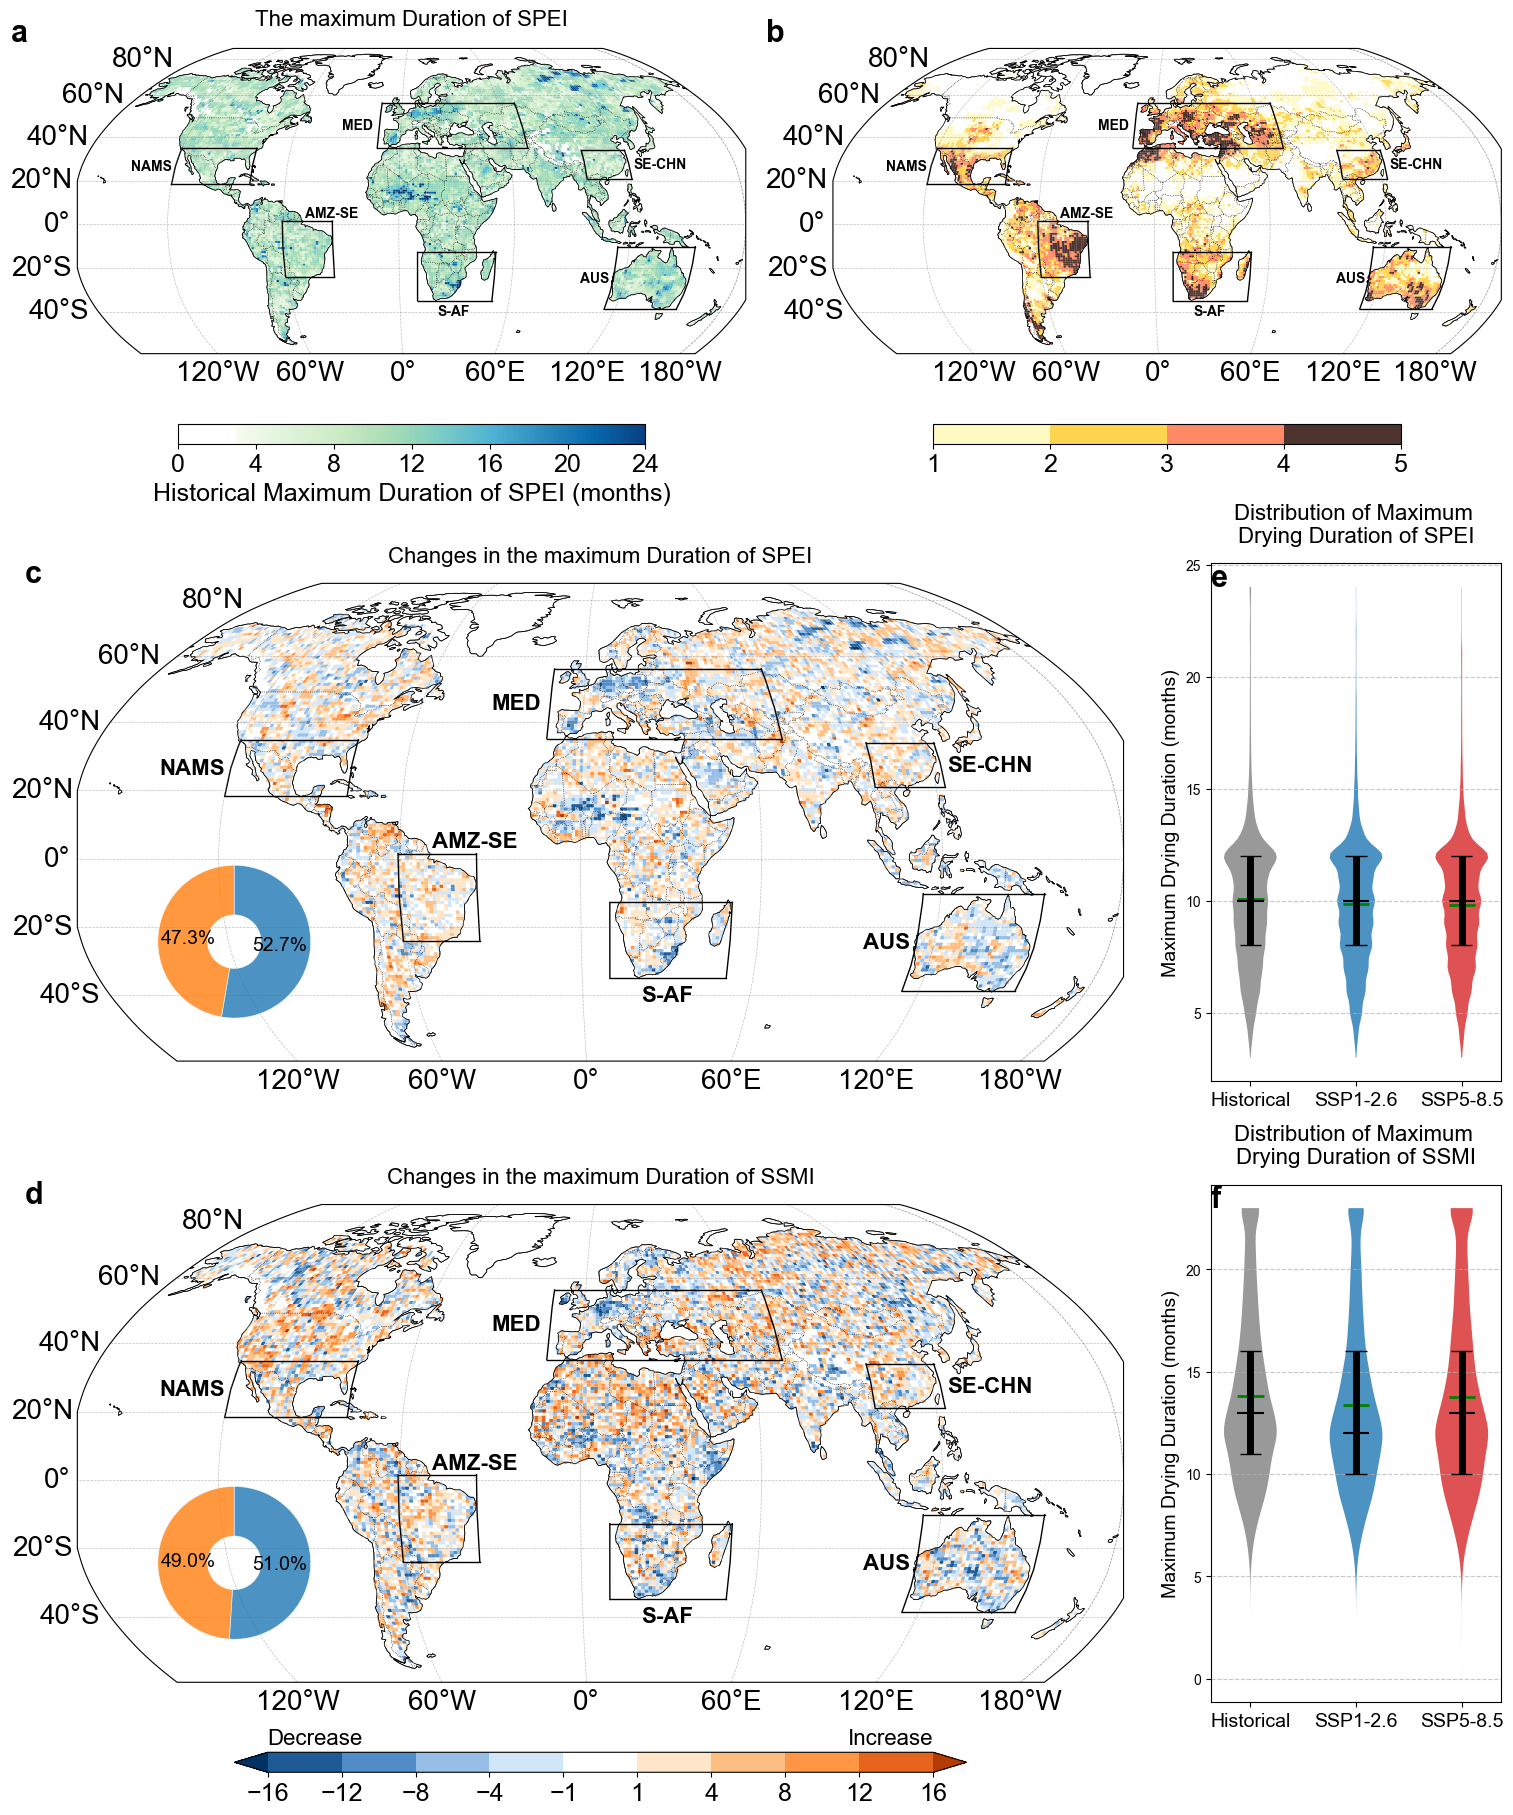

In [8]:
def create_extendedfigure3():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 4, figure=fig, wspace=0.3, hspace=0.2, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第一个子图（图2a）
    ax1 = fig.add_subplot(gs[0, :2], projection=ccrs.Robinson(central_longitude=10))
    mesh1 = plot_extendedfig3a(fig, ax1)
    # 第二个子图（图2b）
    ax2 = fig.add_subplot(gs[0, 2:], projection=ccrs.Robinson(central_longitude=10))
    mesh2 = plot_extendedfig3b(fig, ax2)
    # 第三个子图（图2c）
    ax3 = fig.add_subplot(gs[1, :-1], projection=ccrs.Robinson(central_longitude=10))
    mesh3 = plot_extendedfig3c(fig, ax3)
    # 第四个子图（图2d）
    ax4 = fig.add_subplot(gs[2, :-1], projection=ccrs.Robinson(central_longitude=10))
    mesh4 = plot_extendedfig3d(fig, ax4)
    # 第五个子图（图2e）
    ax5 = fig.add_subplot(gs[1, -1])
    mesh5 = plot_extendedfig3e(fig, ax5)
    # 第六个子图（图2f）
    ax6 = fig.add_subplot(gs[2, -1])
    mesh6 = plot_extendedfig3f(fig, ax6)

    plt.show()

if __name__ == '__main__':
    create_extendedfigure3()